# Automated IAS identification approach using a Machine Learning approach

(Invasive alien species = IAS)

This is an independent thesis-project to classify <i>Rhamnus cathartica</i> using transfer learning in Convolutional Neural Networks (CNN).

All coding dependencies and datasets in this project is published under UWSpace with the original paper titled:
<br>__Identification of Invasive Plant Species using a Machine Learning approach__. 



---


This is test 5 with these parameters:
*   Bands: 4 8 11
*   **Epochs = 100**
*   Size = 6
*   Full dataset

Other notes for this test:
*   **Changed transforms to include flips (both horizontal and vertical)**
*   Fixed dataset to include herbs and crops
*   Contains both types of crops (annual and perennial) as summer season should have no effect
*   Change size = 6 to size (6, 6) to squish image instead
*   Added notes




In [0]:
## saves data on Google Drive + links to datasets
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Mounted at /content/gdrive


In [0]:
## install latest version, but will cause conflicting import errors with old fastai versions
 !curl -s https://course.fast.ai/setup/colab | bash

## uncomment to install old version of fastai
## !pip install fastai==0.7.0
## !pip install torchtext==0.2.3


Updating fastai...
Done.


In [0]:
## install extra dependencies
!pip install rasterio    #used for transform images into JPG format, when needed, and select bands
!pip install sat-search  #used to easily obtain Sentinel-2A data - Link: https://github.com/sat-utils

## install GDAL
!apt install gdal-bin python-gdal python3-gdal 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
## uncomment below to import fastai v0.7 packages instead
## from fastai.imports import *
## from fastai.conv_learner import *
## from fastai.model import *
## from fastai.plots import *


## import fastai v1 packages needed for image classification
from fastai.vision import *
from fastai.metrics import error_rate

## import rasterio + plotting
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt

## import numpy
import numpy as np

## import GDAL
import gdal 

# import callbacks for training data
from fastai.callbacks import *

# histogram import via rasterio
from rasterio.plot import show_hist

# progress bar
from tqdm import tqdm

In [0]:
# show environment details
from fastai.utils.collect_env import *
show_install(True)



```text
=== Software === 
python        : 3.6.7
fastai        : 1.0.51
fastprogress  : 0.1.21
torch         : 1.0.1.post2
nvidia driver : 410.79
torch cuda    : 10.0.130 / is available
torch cudnn   : 7402 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 15079MB | Tesla T4

=== Environment === 
platform      : Linux-4.14.79+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Wed Dec 19 21:19:13 PST 2018
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython

Thu Apr 18 12:27:05 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+--

In [0]:
## list files and folders in the Google Drive connected
#!ls "/content/gdrive/My Drive"


In [0]:
## set main folder to the variable PATH as type Path
PATH = Path(base_dir + 'GEOG490data/')

## **Preprocessing**

#### Convert images to three seleced bands and to .jpg format
bands 4, 8, 11 were selected

In [0]:
#note: band 12 is actually band 11, because of band 8A
#extract input folder data and class names
input_path = PATH/'input'
in_classes = [f for f in list(input_path.iterdir())]

#create new class directories in training folder (uncomment to create)
for i in tqdm(in_classes, desc="Creating directories for training"):
  if not os.path.isdir(Path(PATH/'train'/os.path.basename(i))):
    Path(PATH/'train'/os.path.basename(i)).mkdir(parents=True, exist_ok=False)

#convert Sentinel 13 bands .tiff files to RGB
#for i in in_classes:
#  in_files = list(i.iterdir())
#  for f in tqdm(in_files, desc="Class - " + str(os.path.basename(i))):
#    out_class = os.path.basename(i)
#    out_name = os.path.splitext(os.path.basename(f))[0]
#    os.environ['f_in'] = str(f)
#    os.environ['f_out'] = str(PATH/'train'/out_class/out_name)
#    if not Path(PATH/'train'/out_class/out_name).is_file(): # dont convert the image if it already exists
#      !gdal_translate -of JPEG -scale -b 4 -b 8 -b 12 "$f_in" "$f_out".jpg > RGB_out.log 2> /dev/null
      #print("Converted: " + out_name)

Creating directories for training: 100%|██████████| 10/10 [00:00<00:00, 1483.92it/s]


## Visualization

#### Classes and Size

Highway class has 400
River class has 400
Residential class has 400
RhamnusCathartica class has 421
Forest class has 400
Industrial class has 400
Pasture class has 400
SeaLake class has 400
Crop class has 400
HerbaceousVegetation class has 400
models class has 0


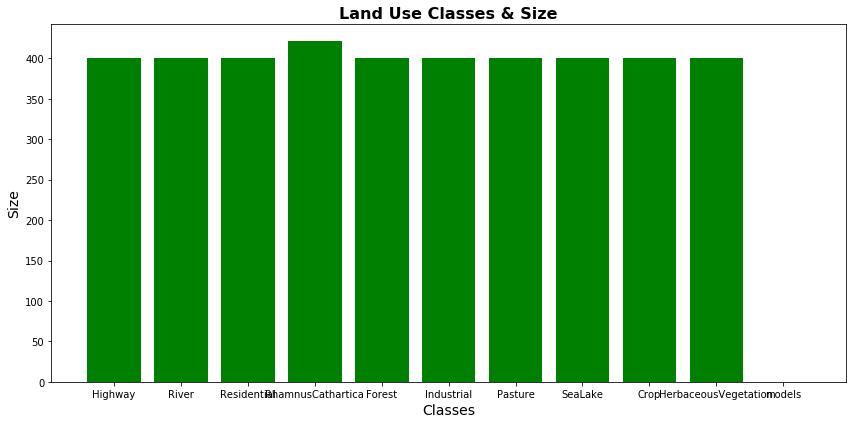

In [0]:
#extract training data and class names
train_path = PATH/'train'
classes = [str(f).split('/')[-1] for f in list(train_path.iterdir())]

files = []
img_files = []
classes_num = {}
for i in classes:
    img_count = 0
    paths = train_path/i
    files.append(list(paths.iterdir())[0])
    for file in os.listdir(paths):
        if file.endswith(".jpg"):
            img_files.append(os.path.join(paths, file))
            img_count += 1
    classes_num[i] = img_count
    print(f'{i} class has ' + str(classes_num[i]))

    
plt.figure(figsize=(15,6))
plt.bar(classes_num.keys(), classes_num.values(), color='g')
plt.title('Land Use Classes & Size', fontsize=16, fontweight='bold')
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Size', fontsize=14)
plt.tight_layout()
plt.savefig(PATH/'class_bargraph.jpg')

In [0]:
temp_dataset = rasterio.open(files[0])
temp_dataset.indexes

(1, 2, 3)

#### Images

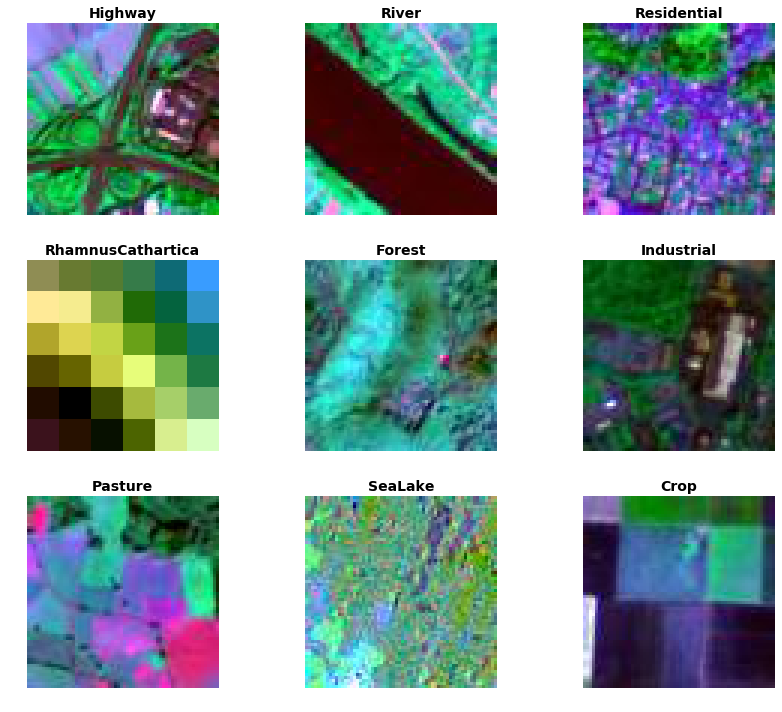

In [0]:
fig = plt.figure(figsize=(12,10))

# Open the file:
#fo = rasterio.open(files[0])

# Normalize bands into 0.0 - 1.0 scale
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

def raster_to_RGB(raster):
  # Convert to numpy arrays
  red = raster.read(1)
  green = raster.read(2)
  blue = raster.read(3)
  # Normalize band DN
  redn = normalize(red)
  greenn = normalize(green)
  bluen = normalize(blue)
  # Stack bands
  return np.dstack((redn, greenn, bluen))


ax1 = plt.subplot(331);plt.axis('off');plt.imshow(raster_to_RGB(rasterio.open(files[0])));ax1.set_title(classes[0], fontsize=14, fontweight='bold')
ax2 = plt.subplot(332);plt.axis('off');plt.imshow(raster_to_RGB(rasterio.open(files[1])));ax2.set_title(classes[1], fontsize=14, fontweight='bold')
ax3 = plt.subplot(333);plt.axis('off');plt.imshow(raster_to_RGB(rasterio.open(files[2])));ax3.set_title(classes[2], fontsize=14, fontweight='bold')

ax1 = plt.subplot(334);plt.axis('off');plt.imshow(raster_to_RGB(rasterio.open(files[3])));ax1.set_title(classes[3], fontsize=14, fontweight='bold')
ax2 = plt.subplot(335);plt.axis('off');plt.imshow(raster_to_RGB(rasterio.open(files[4])));ax2.set_title(classes[4], fontsize=14, fontweight='bold')
ax3 = plt.subplot(336);plt.axis('off');plt.imshow(raster_to_RGB(rasterio.open(files[5])));ax3.set_title(classes[5], fontsize=14, fontweight='bold')

ax1 = plt.subplot(337);plt.axis('off');plt.imshow(raster_to_RGB(rasterio.open(files[6])));ax1.set_title(classes[6], fontsize=14, fontweight='bold')
ax2 = plt.subplot(338);plt.axis('off');plt.imshow(raster_to_RGB(rasterio.open(files[7])));ax2.set_title(classes[7], fontsize=14, fontweight='bold')
ax3 = plt.subplot(339);plt.axis('off');plt.imshow(raster_to_RGB(rasterio.open(files[8])));ax3.set_title(classes[8], fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(PATH/'class_sampleimg.jpg')

#### Histogram of Rhamnus Cathartica

File: /content/gdrive/My Drive/fastai-v3/GEOG490data/train/RhamnusCathartica/T15TWJ_20170706T170236_01.jpg


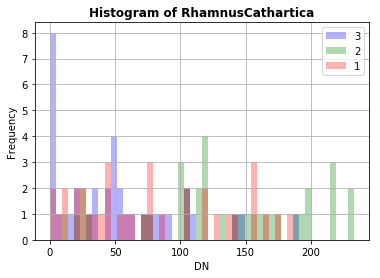

In [0]:
#convert to numpy arrays
raster_hist = rasterio.open(files[3])
print("File: " + str(files[3]))
hist_stack = []
hist_stack.append(raster_hist.read(1))
hist_stack.append(raster_hist.read(2))
hist_stack.append(raster_hist.read(3))
hist_arr = np.array(hist_stack)

show_hist(hist_arr, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram of " + classes[3])

In [0]:
#show RGB histogram of Rhamnus Cathartica for tile 15TWK, made separately from ArcMap
raster_hist = rasterio.open(PATH/'15TWK_Rhamnus.tif')
print("File: " + str(PATH/'15TWK_Rhamnus.tif'))
#hist_stack = []
#hist_stack.append(raster_hist.read(4))
#hist_stack.append(raster_hist.read(3))
#hist_stack.append(raster_hist.read(2))
#hist_arr = np.array(hist_stack)

#show_hist(hist_arr, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="RGB Histogram of Rhamnus cathartica for tile 15TWK")

File: /content/gdrive/My Drive/fastai-v3/GEOG490data/15TWK_Rhamnus.tif


In [0]:
#show full histogram of Rhamnus Cathartica for tile 15TWK, made separately from ArcMap
raster_hist = rasterio.open(PATH/'15TWK_Rhamnus.tif')
print("File: " + str(PATH/'15TWK_Rhamnus.tif'))
#show_hist(raster_hist, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Full Histogram of Rhamnus cathartica for tile 15TWK")

File: /content/gdrive/My Drive/fastai-v3/GEOG490data/15TWK_Rhamnus.tif


## Model

In [0]:
#loading data into our model
train_in = str(PATH/"train")

tfms = get_transforms(do_flip=True, flip_vert=True)
data = (ImageList.from_folder(train_in)
        .split_by_rand_pct()
        .label_from_folder()
        .transform(tfms, size=(6,6))   # squishes the image to 6x6, instead of crop!
        .databunch())


print("Training directory set: " + train_in)

Training directory set: /content/gdrive/My Drive/fastai-v3/GEOG490data/train


In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


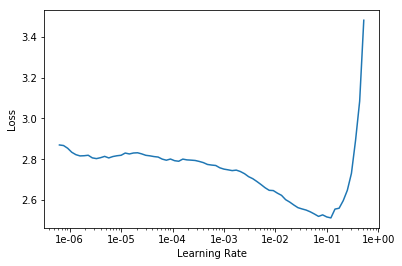

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
#choose low learning rate for fitting
lr = 1e-2

In [0]:
learn.fit_one_cycle(100, max_lr=lr, callbacks=[
                        SaveModelCallback(learn,
                                          every = 'improvement',
                                          monitor = 'error_rate',
                                          mode = 'min',
                                          name = '20190401-rn50-stage1-best')])

epoch,train_loss,valid_loss,error_rate,time
0,2.329569,1.935370,0.664179,00:11
1,2.149296,1.842849,0.621891,00:11
2,2.009511,1.759663,0.582090,00:12
3,1.914149,1.642778,0.570895,00:11
4,1.836157,1.714388,0.557214,00:11
5,1.743730,1.576244,0.537313,00:11
6,1.691365,1.572358,0.546020,00:11
7,1.636980,1.504204,0.519901,00:11
8,1.590514,1.447308,0.512438,00:11
9,1.558055,1.531375,0.496269,00:12


Better model found at epoch 0 with error_rate value: 0.6641790866851807.
Better model found at epoch 1 with error_rate value: 0.6218905448913574.
Better model found at epoch 2 with error_rate value: 0.5820895433425903.
Better model found at epoch 3 with error_rate value: 0.5708954930305481.
Better model found at epoch 4 with error_rate value: 0.5572139024734497.
Better model found at epoch 5 with error_rate value: 0.5373134613037109.
Better model found at epoch 7 with error_rate value: 0.5199005007743835.
Better model found at epoch 8 with error_rate value: 0.5124378204345703.
Better model found at epoch 9 with error_rate value: 0.4962686598300934.
Better model found at epoch 11 with error_rate value: 0.48009949922561646.
Better model found at epoch 12 with error_rate value: 0.46641790866851807.
Better model found at epoch 14 with error_rate value: 0.4552238881587982.
Better model found at epoch 17 with error_rate value: 0.444029837846756.
Better model found at epoch 21 with error_rate

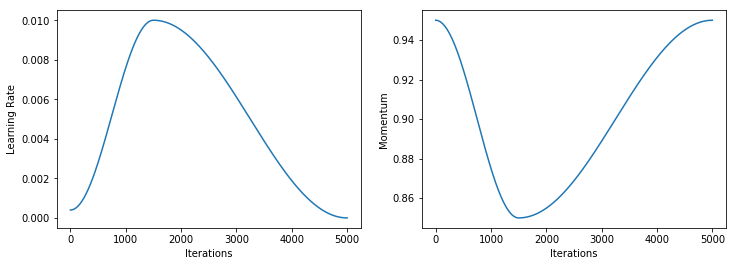

In [0]:
learn.recorder.plot_lr(show_moms=True)

## Analyzing results & Visualization

#### Plot training and validation losses

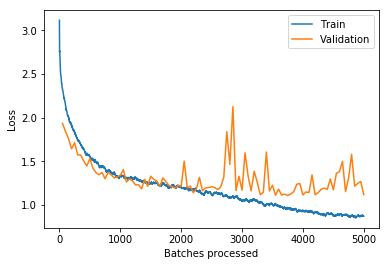

In [0]:
learn.recorder.plot_losses()

#### Evaluation of model

In [0]:
learn.load('20190401-rn50-stage1-best')

Learner(data=ImageDataBunch;

Train: LabelList (3217 items)
x: ImageList
Image (3, 6, 6),Image (3, 6, 6),Image (3, 6, 6),Image (3, 6, 6),Image (3, 6, 6)
y: CategoryList
Highway,Highway,Highway,Highway,Highway
Path: /content/gdrive/My Drive/fastai-v3/GEOG490data/train;

Valid: LabelList (804 items)
x: ImageList
Image (3, 6, 6),Image (3, 6, 6),Image (3, 6, 6),Image (3, 6, 6),Image (3, 6, 6)
y: CategoryList
RhamnusCathartica,Industrial,River,River,River
Path: /content/gdrive/My Drive/fastai-v3/GEOG490data/train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64,

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

#### Top 25 misclassified samples, sorted by respective loss
Show images in top_losses along with their prediction, actual, loss, and probability of actual class. Uses Grad-CAM overview heatmap: where the model looks to make a decision.

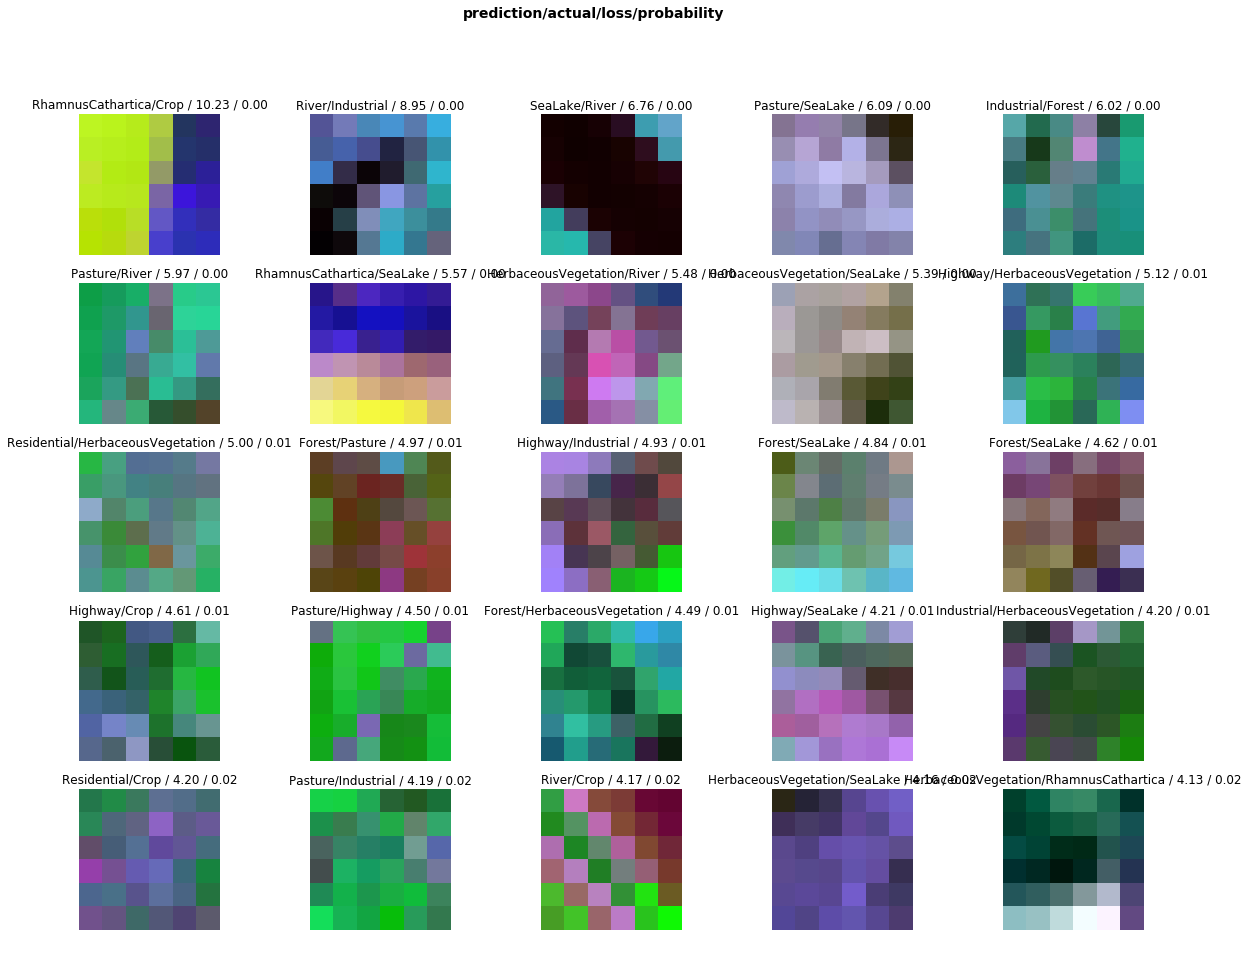

In [0]:
interp.plot_top_losses(25, figsize=(20,15))

#### Confusion matrix

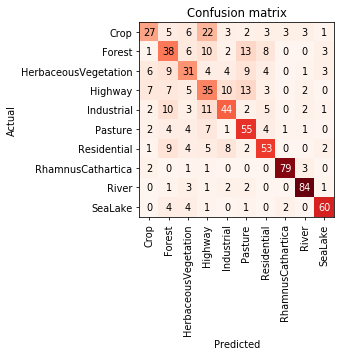

In [0]:
interp.plot_confusion_matrix(figsize=(5,5), cmap='Reds', dpi=70)

In [0]:
interp.most_confused(min_val=2)

[('Crop', 'Highway', 22),
 ('Forest', 'Pasture', 13),
 ('Highway', 'Pasture', 13),
 ('Industrial', 'Highway', 11),
 ('Forest', 'Highway', 10),
 ('Highway', 'Industrial', 10),
 ('Industrial', 'Forest', 10),
 ('HerbaceousVegetation', 'Forest', 9),
 ('HerbaceousVegetation', 'Pasture', 9),
 ('Residential', 'Forest', 9),
 ('Forest', 'Residential', 8),
 ('Residential', 'Industrial', 8),
 ('Highway', 'Crop', 7),
 ('Highway', 'Forest', 7),
 ('Pasture', 'Highway', 7),
 ('Crop', 'HerbaceousVegetation', 6),
 ('Forest', 'HerbaceousVegetation', 6),
 ('HerbaceousVegetation', 'Crop', 6),
 ('Crop', 'Forest', 5),
 ('Highway', 'HerbaceousVegetation', 5),
 ('Industrial', 'Residential', 5),
 ('Residential', 'Highway', 5),
 ('HerbaceousVegetation', 'Highway', 4),
 ('HerbaceousVegetation', 'Industrial', 4),
 ('HerbaceousVegetation', 'Residential', 4),
 ('Pasture', 'Forest', 4),
 ('Pasture', 'HerbaceousVegetation', 4),
 ('Pasture', 'Residential', 4),
 ('Residential', 'HerbaceousVegetation', 4),
 ('SeaLake', 

### Experimenting on test data

#### Trial run on one test file

In [0]:
#convert test files to .JPG with specific bands
test_path = PATH/'test'
if not os.path.isdir(Path(PATH/'testJPG')):
  Path(PATH/'testJPG').mkdir(parents=True, exist_ok=False)

in_test_files = [f for f in list(test_path.iterdir()) if '.tif' in f.name]
for f in tqdm(in_test_files, desc="Processing test files"):
  out_name = os.path.splitext(os.path.basename(f))[0]
  os.environ['f_in'] = str(f)
  os.environ['f_out'] = str(PATH/'testJPG'/out_name)
  !gdal_translate -of JPEG -scale -b 4 -b 8 -b 11 "$f_in" "$f_out".jpg  > test_out.log 2> /dev/null
  print("Converted: " + out_name)

Processing test files:   7%|▋         | 1/14 [00:03<00:51,  3.94s/it]

Converted: T17TNJ_20170721T162051_01


Processing test files:  14%|█▍        | 2/14 [00:05<00:38,  3.18s/it]

Converted: T17TNJ_20170721T162051_02


Processing test files:  21%|██▏       | 3/14 [00:06<00:29,  2.65s/it]

Converted: T17TNJ_20170721T162051_03


Processing test files:  29%|██▊       | 4/14 [00:08<00:22,  2.24s/it]

Converted: T17TNJ_20170721T162051_04


Processing test files:  36%|███▌      | 5/14 [00:09<00:16,  1.89s/it]

Converted: T17TNJ_20170721T162051_05


Processing test files:  43%|████▎     | 6/14 [00:10<00:13,  1.66s/it]

Converted: T17TNJ_20170721T162051_06


Processing test files:  50%|█████     | 7/14 [00:11<00:10,  1.55s/it]

Converted: T17TNJ_20170721T162051_07


Processing test files:  57%|█████▋    | 8/14 [00:12<00:08,  1.45s/it]

Converted: T17TNJ_20170721T162051_08


Processing test files:  64%|██████▍   | 9/14 [00:13<00:06,  1.37s/it]

Converted: T17TNJ_20170721T162051_09


Processing test files:  71%|███████▏  | 10/14 [00:14<00:05,  1.27s/it]

Converted: T17TNJ_20170721T162051_10


Processing test files:  79%|███████▊  | 11/14 [00:16<00:03,  1.31s/it]

Converted: T17TNJ_20170721T162051_11


Processing test files:  86%|████████▌ | 12/14 [00:17<00:02,  1.25s/it]

Converted: T17TNJ_20170721T162051_12


Processing test files:  93%|█████████▎| 13/14 [00:18<00:01,  1.14s/it]

Converted: T17TNJ_20170721T162051_13


Processing test files: 100%|██████████| 14/14 [00:19<00:00,  1.13s/it]

Converted: T17TNJ_20170721T162051_14


In [0]:
#load test data
test_path = PATH/'testJPG'
test_files = [f for f in list(test_path.iterdir()) if not '.xml' in f.name]
print(len(test_files))

14


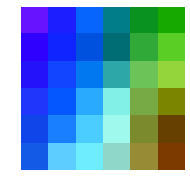

In [0]:
#sample image from ontario
img = open_image(test_files[1])
img.show()

In [0]:
learn.predict(img)

(Category RhamnusCathartica,
 tensor(7),
 tensor([2.6855e-05, 1.2117e-07, 3.5964e-07, 1.3601e-05, 5.8523e-07, 1.6531e-06,
         2.8971e-08, 9.9994e-01, 1.8747e-06, 1.9768e-05]))

#### Confidence and assessment of test data

In [0]:
preds = []
pred_classes = []
for fn in test_files:
    try: 
        img = open_image(fn)
        img = img.apply_tfms(tfms[1],resize_method=ResizeMethod.SQUISH, padding_mode='zeros')
        pred_class,pred_idx,outputs = learn.predict(img)
        preds.append(list(to_np(outputs)))
        pred_classes.append(str(pred_class))
    except Exception as exc: 
        print(f'{exc}') 
        preds.append([-1,-1,-1,-1])
        pred_classes.append('error')

df = pd.DataFrame(data=preds, columns=data.classes)
df['fname'] = [f.name for f in test_files[:len(preds)]]
df['predicted_class'] = pred_classes
df.head(25)

,Crop,Forest,HerbaceousVegetation,Highway,Industrial,Pasture,Residential,RhamnusCathartica,River,SeaLake,fname,predicted_class
0,0.021994,8.236292e-02,4.063443e-03,0.083961,2.222238e-02,0.431623,1.428104e-02,0.277915,0.037476,0.024102,T17TNJ_20170721T162051_01.jpg,Pasture
1,0.000027,1.211656e-07,3.596427e-07,0.000014,5.852293e-07,0.000002,2.897052e-08,0.999935,0.000002,0.000020,T17TNJ_20170721T162051_02.jpg,RhamnusCathartica
2,0.000396,1.447780e-04,3.084007e-05,0.002501,1.097372e-04,0.001516,6.651777e-06,0.994927,0.000258,0.000110,T17TNJ_20170721T162051_03.jpg,RhamnusCathartica
3,0.000090,4.814184e-04,6.179509e-05,0.000450,6.650112e-05,0.000397,4.605104e-06,0.000068,0.998374,0.000007,T17TNJ_20170721T162051_04.jpg,River
4,0.001919,2.477731e-04,1.436093e-04,0.001257,2.465467e-04,0.000612,4.301870e-05,0.918879,0.051205,0.025447,T17TNJ_20170721T162051_05.jpg,RhamnusCathartica
5,0.100553,4.168566e-02,4.047566e-02,0.067701,1.680279e-02,0.503030,3.402439e-03,0.156422,0.047472,0.022455,T17TNJ_20170721T162051_06.jpg,Pasture
6,0.002075,4.407737e-05,3.152298e-04,0.002688,3.173843e-04,0.000603,2.040504e-05,0.973136,0.000186,0.020616,T17TNJ_20170721T162051_08.jpg,RhamnusCathartica
7,0.012106,2.562117e-02,1.003972e-03,0.025474,9.756342e-03,0.326995,4.850502e-03,0.584693,0.005617,0.003883,T17TNJ_20170721T162051_07.jpg,RhamnusCathartica
8,0.001833,1.300538e-05,3.535987e-05,0.001264,2.643923e-05,0.000163,1.747262e-06,0.985212,0.011399,0.000053,T17TNJ_20170721T162051_09.jpg,RhamnusCathartica
9,0.260931,2.558632e-02,9.725244e-02,0.118790,3.810775e-02,0.292837,7.897953e-03,0.061815,0.050150,0.046632,T17TNJ_20170721T162051_11.jpg,Pasture


ID 0 Pasture  category confidence: 0.43162253499031067


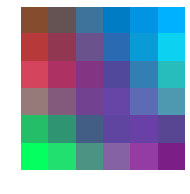

ID 1 RhamnusCathartica  category confidence: 0.9999351501464844


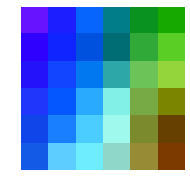

ID 2 RhamnusCathartica  category confidence: 0.994927167892456


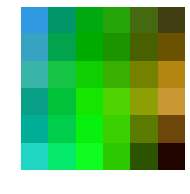

ID 3 River  category confidence: 0.998374342918396


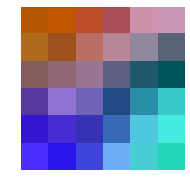

ID 4 RhamnusCathartica  category confidence: 0.9188787937164307


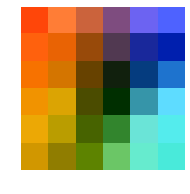

ID 5 Pasture  category confidence: 0.5030295252799988


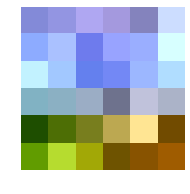

ID 6 RhamnusCathartica  category confidence: 0.9731359481811523


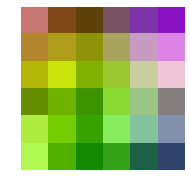

ID 7 RhamnusCathartica  category confidence: 0.584693431854248


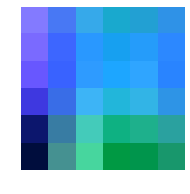

ID 8 RhamnusCathartica  category confidence: 0.9852122068405151


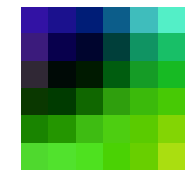

ID 9 Pasture  category confidence: 0.29283657670021057


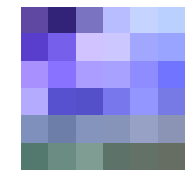

ID 10 RhamnusCathartica  category confidence: 0.9854957461357117


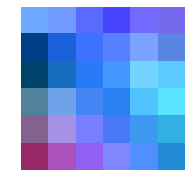

ID 11 RhamnusCathartica  category confidence: 0.7339289784431458


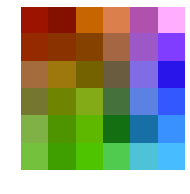

ID 12 RhamnusCathartica  category confidence: 0.4213064908981323


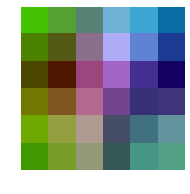

ID 13 SeaLake  category confidence: 0.684092104434967


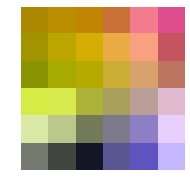

In [0]:
for i in range(14):
    img = open_image(test_path/df.iloc[i]['fname'])
    print("ID", str(i), df.iloc[i]['predicted_class'], ' category confidence:', df[df.iloc[i]['predicted_class']].iloc[i])
    img.show()
    plt.show()